# Time Series Forecasting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from datetime import datetime

In [2]:
# statsmodels required to use the ARIMA model
# pip install statsmodels
from statsmodels.tsa.arima.model import ARIMA
# scikit-learn required for performance metrics
# pip install scipy
# pip install scikit-learn
from sklearn.metrics import mean_squared_error

We will use a basic **ARIMA** model:
* Autoregression
* Integrated
* Moving Average

# Data Preparation

This data has been pre-prepared for modeling:
* continuous
* does not contain nan values

In [3]:
df = pickle.load(open('assets/df.p', 'rb'))

In [4]:
df.head()

,Biomass,Geothermal,HydroElectric,Thermal,Solar,Wind
Date,,,,,,
2016-12-27 00:00:00,105.04,178.45,0.41,104.51,3.06,0.49
2016-12-27 01:00:00,103.92,178.71,0.41,84.67,3.06,0.49
2016-12-27 02:00:00,103.38,177.92,0.40,73.57,3.06,0.49
2016-12-27 03:00:00,102.66,177.99,0.40,73.19,3.06,0.49
2016-12-27 04:00:00,102.33,179.00,0.40,83.59,3.06,0.49


## <span style="color:cyan">Visulaizing the Data</span>

We want to better visulaize the seasonality and overall trend in the  
data. This way we can make decisions on how to prep and model it.  
Since we have a large amount of data (almost 4 years) we will use a  
rolling average with a window of 2 weeks (14 days).

In [5]:
rolling_avg = df.rolling(window = 336).mean()

Text(0.5, 1.0, 'Electrical Generation for El Salvador')

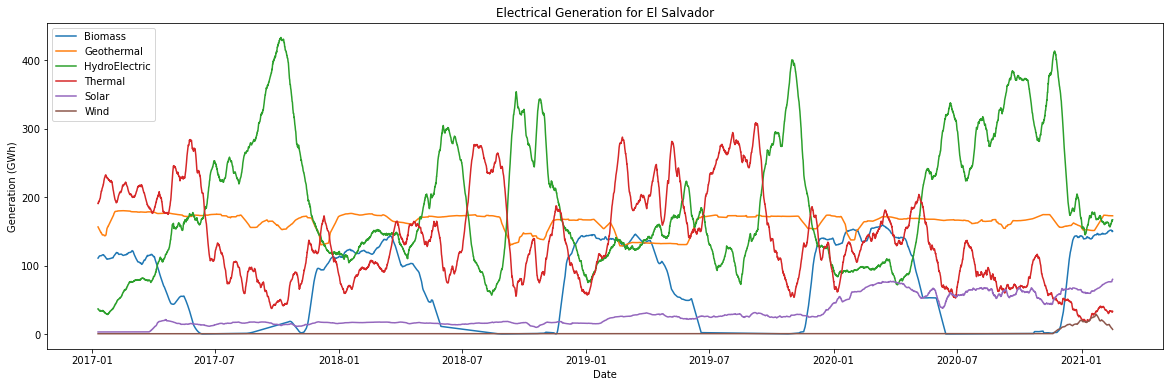

In [6]:
# plot ALL the data
fig, ax = plt.subplots(figsize = (20,6))
for energy in rolling_avg.columns:
    ax.plot(rolling_avg[energy], label=energy)
ax.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Generation (GWh)')
ax.set_title('Electrical Generation for El Salvador')

## <span style="color:cyan">Examples of Seasonality and Trend</span>

Text(0.5, 1.0, 'Biomass Generation for El Salvador')

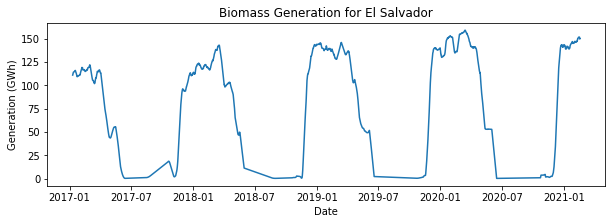

In [7]:
# biomass is seasonal
fig, ax = plt.subplots(figsize = (10,3))
ax.plot(rolling_avg['Biomass'], color='tab:blue')
ax.set_xlabel('Date')
ax.set_ylabel('Generation (GWh)')
ax.set_title('Biomass Generation for El Salvador')

Text(0.5, 1.0, 'Solar Generation for El Salvador')

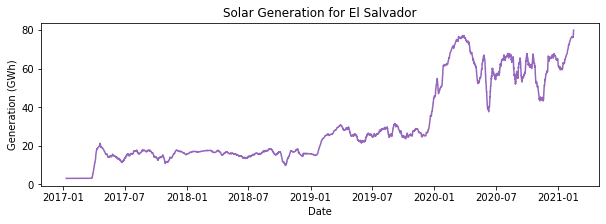

In [8]:
# solar is increasing
fig, ax = plt.subplots(figsize = (10,3))
ax.plot(rolling_avg['Solar'], color='tab:purple')
ax.set_xlabel('Date')
ax.set_ylabel('Generation (GWh)')
ax.set_title('Solar Generation for El Salvador')

## <span style="color:cyan">Sationarizing the Data</span>

To stationarize the data we will use first order differencing. This is  
exactly the same as taking the first derivative of the data.  
$\Large y_{t} = y_{t} - y_{t-1}$  
  
Assuming first order differencing is enough, the result should look  
like "white noise".

In [9]:
# detrend by taking 1st derivative
df_deriv = df - df.shift(1)
# remove first entry (nan)
df_deriv = df_deriv[1:]

Text(0.5, 1.0, 'Geothermal Energy (Stationary)')

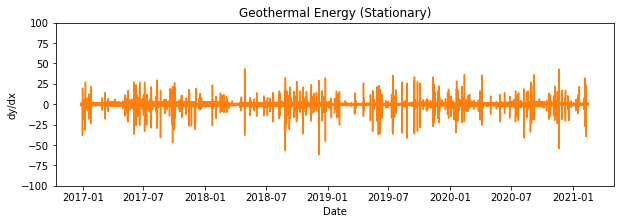

In [10]:
fig, ax = plt.subplots(figsize = (10,3))
ax.plot(df_deriv['Geothermal'], color='tab:orange')
ax.set_xlabel('Date')
ax.set_ylabel('dy/dx')
ax.set_ylim([-100,100])
ax.set_title('Geothermal Energy (Stationary)')

# Modeling

ARIMA(p,d,q)
* p: lag order
* d: degree of differencing
* q: order of moving average  
  
**Goal**: we will try to predict the HydroElectric energy for january  
1st, 2020, using the past 3 years as training data.

In [49]:
train = df['HydroElectric']['2017-01-01':'2019-12-31'].tolist()
test = df['HydroElectric']['2020-01-01':'2020-01-01'].tolist()
history = train.copy()

## <span style="color:cyan">ARIMA(1,1,1)</span>

In [50]:
# walk-forward validation
predictions = list()
for t in range(len(test)):
    # fit model
    model = ARIMA(history, order=(2,1,1)).fit()
    
    # get forecast for next hour
    y_hat = model.forecast()[0]
    # expected value
    y_actual = test[t]
    
    predictions.append(y_hat)
    history.append(y_actual)
    print('predicted=%f, expected=%f' % (y_hat, y_actual))

C:\Users\MaxAy\anaconda3\envs\forecast_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\MaxAy\anaconda3\envs\forecast_env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


predicted=82.111538, expected=51.900000
predicted=41.088972, expected=15.370000
predicted=12.082886, expected=14.600000
predicted=25.913226, expected=13.910000
predicted=25.245221, expected=13.660000
predicted=25.098469, expected=15.580000
predicted=27.500270, expected=12.520000
predicted=22.760900, expected=22.490000
predicted=36.428229, expected=46.570000
predicted=62.527846, expected=31.910000
predicted=34.212308, expected=40.310000
predicted=50.672635, expected=49.260000
predicted=58.424972, expected=41.340000
predicted=44.763051, expected=41.920000
predicted=48.659403, expected=57.230000
predicted=67.601767, expected=36.430000
predicted=35.168912, expected=93.200000
predicted=114.940038, expected=169.490000
predicted=187.671207, expected=302.830000
predicted=324.268294, expected=337.830000
predicted=314.152716, expected=299.790000
predicted=252.410222, expected=201.960000
predicted=145.266835, expected=95.150000
predicted=51.105479, expected=11.710000


## <span style="color:cyan">Analysis</span>

In [51]:
# evaluate forecasts
rmse = mean_squared_error(test, predictions)**(0.5)
print('Test RMSE: %.3f' % rmse)

Test RMSE: 36.057


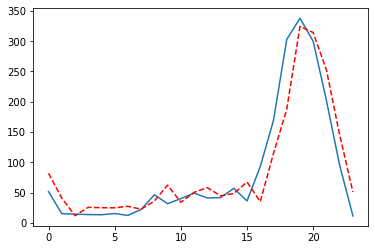

In [52]:
# plot predicted vs expected
plt.plot(test)
plt.plot(predictions, 'r--')
plt.show()

# Long-Term Forecasting

In [45]:
daily_data = df.resample('D').sum()
train = daily_data['HydroElectric']['2017-01-01':'2018-12-31']
test = daily_data['HydroElectric']['2019-01-01':'2019-01-07']

In [46]:
# fit model
model = ARIMA(train, order=(7,1,1))
model_fit = model.fit()

In [47]:
# out-of sample forecast
forecast = model_fit.forecast(steps=7)

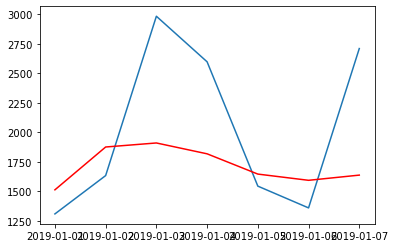

In [48]:
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(forecast, 'r--')
plt.show()

The ARIMA model is not without limitations. Specifically,  
it can struggle to predict far into the future. Luckily,  
Many other models have been built based off of ARIMA  
that do not share this problem.